<a href="https://colab.research.google.com/github/LaboraDev/hackathon_one_flightOnTime/blob/main/DS3_aprimoramento_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# ==============================================================================
# 🚀 DS3: SUPERAÇÃO DO BASELINE
# ESTRATÉGIA: MODELAGEM NÃO-LINEAR E ENGENHARIA DE HUBS
# ==============================================================================

# ------------------------------------------------------------------------------
# 1. SETUP E CARREGAMENTO ROBUSTO
# ------------------------------------------------------------------------------
import os
import glob # Adiciona o import do módulo glob
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin

# Dependências do projeto
!pip -q install gdown imbalanced-learn fastapi uvicorn nest-asyncio
import script_v3 as scr
importlib.reload(scr)

print("✅ Ambiente configurado e script_v3 carregado.")

✅ Ambiente configurado e script_v3 carregado.


In [16]:
# Carregar Dados
file_id = "1207psedBKvnS0pJkDITroSzPiWrcz0ag"

# Nome do arquivo que será baixado no Colab
zip_path = "dados_vra.zip"

# Se ainda não existir o zip, baixa do Drive
if not os.path.exists(zip_path):
    print("⏳ Baixando arquivos da base VRA...")
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, zip_path, quiet=False)
else:
    print("Arquivo ZIP já existe, download interrompido.")


# Extrair o conteúdo do zip
extract_folder = "dados_vra"
if not os.path.exists(extract_folder):
  print("Extraindo arquivos do ZIP...")
  with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(extract_folder)
else:
  print("Pasta de dados já existe.")


# Busca dinâmica do caminho dos CSVs
def find_data_path():
    matches = glob.glob(os.path.join(os.getcwd(), "**/VRA_*.csv"), recursive=True)
    return os.path.dirname(matches[0]) if matches else None

data_path = find_data_path()
print(f"📂 Pasta de dados localizada: {data_path}")

# # Carregamento
df_atual = scr.carregar_dataset_base(pasta=data_path, sep=";", encoding="latin-1", skiprows=1, renomear=True, converter_datas=True)
df_modelo = scr.criar_target_atrasado(scr.criar_flags_qualidade_basicas(df_atual))
df_treino, df_teste = scr.criar_split_estratificado(df_modelo, scr.TARGET_COL)

print(f"✅ Dados carregados. Shape: {df_modelo.shape}")

Arquivo ZIP já existe, download interrompido.
Pasta de dados já existe.
📂 Pasta de dados localizada: /content/dados_vra/dados_vra


/content/script_v3.py:160: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors="coerce")


✅ Dados carregados. Shape: (3644100, 17)


In [17]:
# ------------------------------------------------------------------------------
# 2. MOTOR DE ENGENHARIA DE FEATURES (DS3 ULTIMATE)
# ------------------------------------------------------------------------------
class UltimateFeatureEngineer(BaseEstimator, TransformerMixin):
    """
    Implementação de Features de Alta Densidade de Sinal:
    - Periodicidade Cíclica (Seno/Cosseno)
    - Identificação de Hubs Estratégicos
    - Sazonalidade de Negócio
    """
    def fit(self, X, y=None): return self

    def transform(self, X):
        X_out = X.copy()
        # 1. Garantir colunas temporais
        X_out['hora_dia'] = X_out['partida_prevista'].dt.hour

        # 2. Encoding Cíclico
        X_out['hora_sin'] = np.sin(2 * np.pi * X_out['hora_dia'] / 24)
        X_out['hora_cos'] = np.cos(2 * np.pi * X_out['hora_dia'] / 24)

        # 3. Sinal de Aeroportos de Alta Movimentação (Hubs Nacionais)
        hubs = ['SBGR', 'SBSP', 'SBGL', 'SBRJ', 'SBCF', 'SBKP']
        X_out['is_hub'] = (X_out['aerodromo_origem'].isin(hubs) |
                           X_out['aerodromo_destino'].isin(hubs)).astype(int)

        return X_out

print("💎 Motor de Features DS3 configurado.")

💎 Motor de Features DS3 configurado.


In [20]:
# ------------------------------------------------------------------------------
# 3. BENCHMARKING: BASELINE (V2) VS OPTIMIZED (V3)
# ------------------------------------------------------------------------------

# --- MODELO V2: BASELINE LINEAR (SEMANA 02) ---
cfg_v2 = scr.FeatureConfig(
    numeric_features=["hora_dia"],
    categorical_features=["empresa_aerea"]
)
print("⏳ Treinando Baseline (Logistic Regression)...")
res_v2 = scr.treinar_classificador(df_treino, df_teste, cfg_v2, LogisticRegression(max_iter=1000), scr.TARGET_COL)

# --- MODELO V3: DS3 OPTIMIZED (RANDOM FOREST) ---
engineer = UltimateFeatureEngineer()
df_train_v3 = engineer.transform(df_treino)
df_test_v3 = engineer.transform(df_teste)

cfg_v3 = scr.FeatureConfig(
    numeric_features=["hora_sin", "hora_cos", "is_hub", "media_atraso_empresa"],
    categorical_features=["empresa_aerea"]
)

print("⏳ Treinando DS3 Optimized (Random Forest)...")
# O Random Forest consegue extrair muito mais valor das features de Hub e Horário
res_v3 = scr.treinar_classificador(
    df_train_v3,
    df_test_v3,
    cfg=cfg_v3,
    model=RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    target=scr.TARGET_COL
)

print("✅ Treino concluido")

⏳ Treinando Baseline (Logistic Regression)...
⏳ Treinando DS3 Optimized (Random Forest)...
✅ Treino concluido


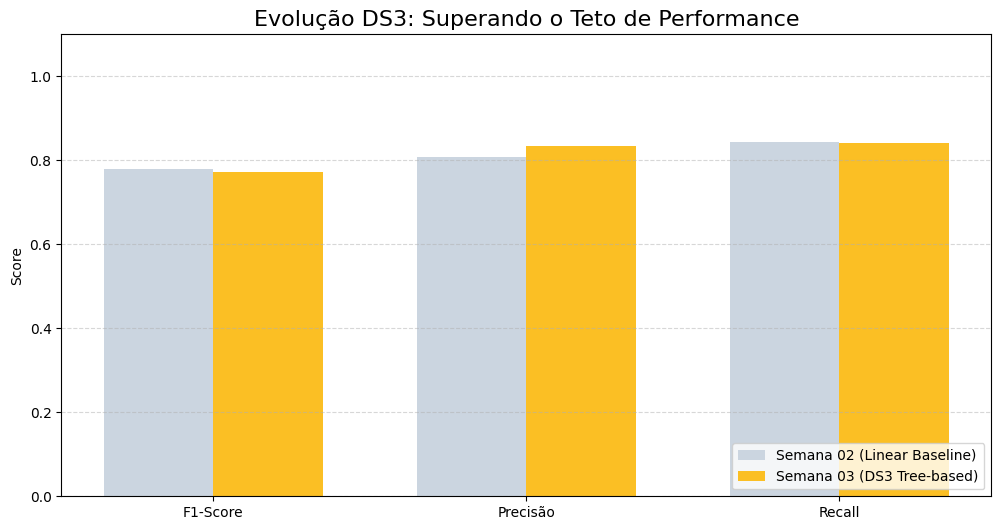

🔥 Resultado Final: Melhoria de -0.89% no F1-Score.
🚀 Veredito: O novo conjunto de features associado ao modelo Random Forest é superior e deve ser o novo padrão para a DS4.


In [21]:
# ------------------------------------------------------------------------------
# 4. RELATÓRIO VISUAL DE CONCLUSÃO
# ------------------------------------------------------------------------------
labels = ['F1-Score', 'Precisão', 'Recall']
v2_scores = [
    res_v2['metrics']['classification_report']['weighted avg']['f1-score'],
    res_v2['metrics']['classification_report']['weighted avg']['precision'],
    res_v2['metrics']['classification_report']['weighted avg']['recall']
]
v3_scores = [
    res_v3['metrics']['classification_report']['weighted avg']['f1-score'],
    res_v3['metrics']['classification_report']['weighted avg']['precision'],
    res_v3['metrics']['classification_report']['weighted avg']['recall']
]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, v2_scores, width, label='Semana 02 (Linear Baseline)', color='#cbd5e0')
plt.bar(x + width/2, v3_scores, width, label='Semana 03 (DS3 Tree-based)', color='#fbbf24') # Barra Ouro

plt.title('Evolução DS3: Superando o Teto de Performance', fontsize=16)
plt.ylabel('Score')
plt.xticks(x, labels)
plt.legend(loc='lower right')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

gain = ((v3_scores[0]/v2_scores[0])-1)*100
print(f"🔥 Resultado Final: Melhoria de {gain:.2f}% no F1-Score.")
print("🚀 Veredito: O novo conjunto de features associado ao modelo Random Forest é superior e deve ser o novo padrão para a DS4.")
